<a href="https://colab.research.google.com/github/iiVSX/SWE3032_41_team10/blob/main/src/New11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Dataset.xlsx to Dataset.xlsx


# 전처리 및 데이터 준비

In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.0 MB/s eta 0:00:00


In [5]:
import pandas as pd

# 데이터셋 불러오기
data = pd.read_excel('Dataset.xlsx')

In [6]:
happy_data = data[data['감정'] == '행복']
sad_data = data[data['감정'] == '슬픔']
fear_data = data[data['감정'] == '공포']
neutral_data = data[data['감정'] == '중립']
anger_data = data[data['감정'] == '분노']
aversion_data = data[data['감정'] == '혐오']
surprise_data = data[data['감정'] == '놀람']

print(len(happy_data))
print(len(sad_data))
print(len(fear_data))
print(len(neutral_data))
print(len(anger_data))
print(len(aversion_data))
print(len(surprise_data))

11615
21239
9697
51900
20934
10308
12519


In [7]:
from sklearn.utils import resample

minority_data_size = 9000

happy_data_resampled = resample(happy_data, replace=False, n_samples=minority_data_size, random_state=42)
sad_data_resampled = resample(sad_data, replace=False, n_samples=minority_data_size, random_state=42)
fear_data_resampled = resample(fear_data, replace=False, n_samples=minority_data_size, random_state=42)
neutral_data_resampled = resample(neutral_data, replace=False, n_samples=minority_data_size, random_state=42)
anger_data_resampled = resample(anger_data, replace=False, n_samples=minority_data_size, random_state=42)
aversion_data_resampled = resample(aversion_data, replace=False, n_samples=minority_data_size, random_state=42)
surprise_data_resampled = resample(surprise_data, replace=False, n_samples=minority_data_size, random_state=42)

data = pd.concat([happy_data_resampled, sad_data_resampled, fear_data_resampled, neutral_data_resampled, anger_data_resampled, aversion_data_resampled, surprise_data_resampled])

print(data)

                                                       문장  감정
88040                      끝까지 한번 가보자끝까지해 ~~!!!!!!ㅋㅋㅋㅋㅋㅋㅋ  행복
121949      사람들한테 내가 이벤트에 당첨 돼서 갖고 싶었던 향수를 선물로 받았다고 자랑했어.  행복
122817  내가 10km 마라톤 대회에 출전했는데 이전의 내 기록을 훨씬 갱신했어. 너무 기분...  행복
85385                                        과학자들 존경스럽군ㅎㅎ  행복
83696                                   좋은기사..한참동안 읽었네요^^  행복
...                                                   ...  ..
23541                                           네? 그건 왜..  놀람
64807                                     그거 알면서 가는거 아니냐?  놀람
64317             애타게 찾다가 못잦아서 단념했는데내릴때 저 멀리서 일행분이랑 계셨어요!  놀람
4793                                        어, 어떻게 해야 하지?  놀람
65762                                    그사이에 남친생기면 어떻하죠?  놀람

[63000 rows x 2 columns]


In [8]:
from transformers import ElectraForSequenceClassification, ElectraTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# 데이터셋 전처리
sentences = data['문장'].tolist()
labels = data['감정'].tolist()

# 각 문장을 토큰화하기
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# 가장 긴 문장을 확인
max_len = 0
for sentence in tokenized_texts:
    max_len = max(max_len, len(sentence))
MAX_LEN = max_len

# 토큰을 인덱스로 변환하고 패딩하기
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# 어텐션 마스크 생성하기
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

# label 정수화
label_dict = {'행복':0, '슬픔':1, '공포':2, '중립':3, '분노':4, '혐오':5, '놀람':6}
labels = [label_dict[label] for label in labels]

In [9]:
from sklearn.model_selection import train_test_split

train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.2)
train_masks, test_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42, test_size=0.2)

In [10]:
import numpy as np

def one_hot_encode(labels, num_classes):
    encoded_labels = np.zeros((len(labels), num_classes))
    for i, label in enumerate(labels):
        encoded_labels[i][label] = 1
    return encoded_labels

In [11]:
num_classes = len(set(train_labels))
encoded_train_labels = one_hot_encode(train_labels, num_classes)

In [18]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import ElectraTokenizer, ElectraForSequenceClassification, AdamW

# GPU 사용 여부
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 학습 데이터셋 로드
train_inputs = torch.tensor(train_inputs)
test_inputs = torch.tensor(test_inputs)
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)
train_masks = torch.tensor(train_masks)
test_masks = torch.tensor(test_masks)

# 배치 사이즈
batch_size = 32

# 데이터셋 로드 및 샘플링 방식 설정
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# 모델 정의
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-small-v3-discriminator", num_labels=7)
model.to(device)

# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=5e-5)  

<ipython-input-18-ee3a959656d8>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs)
<ipython-input-18-ee3a959656d8>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(test_inputs)
<ipython-input-18-ee3a959656d8>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels)
<ipython-input-18-ee3a959656d8>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requi

Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized

In [19]:
def flat_accuracy(preds, labels):
    """
    정확도 계산 함수
    """
    preds_flat = np.argmax(preds, axis=1).flatten() # 예측값에서 가장 큰 값의 인덱스를 추출하여 1차원으로 만듦
    labels_flat = labels.flatten() # 실제값을 1차원으로 만듦
    return np.sum(preds_flat == labels_flat) / len(labels_flat)

# 일반 학습

In [14]:
import matplotlib.pyplot as plt

In [15]:
train_accuracies = []
test_accuracies = []

num_epochs = 10
# 모델 학습
for epoch in range(num_epochs):
    # 학습 모드로 변경
    model.train()
    
    # 손실값 초기화
    total_train_accuracy = 0
    total_train_loss = 0
    
    # 배치별로 학습
    for step, batch in enumerate(train_dataloader):
        # 배치 데이터 GPU로 이동
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # 그래디언트 초기화
        optimizer.zero_grad()
        
        # forward 수행
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        
        # 손실값 누적
        total_train_loss += loss.item()
        
        # 예측값 추출
        preds = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 정확도 계산
        total_train_accuracy += flat_accuracy(preds, label_ids)
        
        # backward 수행 및 그래디언트 클리핑
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # 옵티마이저 업데이트
        optimizer.step()
        
    # 평균 손실값 계산
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    avg_train_loss = total_train_loss / len(train_dataloader)
    
    # 검증 모드로 변경
    model.eval()
    
    # 검증 데이터셋
    total_test_accuracy = 0
    total_test_loss = 0
    
    for batch in test_dataloader:
        # 배치 데이터 GPU로 이동
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # 그래디언트 계산하지 않음
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]
            
        # 검증 손실값 누적
        total_test_loss += loss.item()
        
        # 예측값 추출
        preds = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 정확도 계산
        total_test_accuracy += flat_accuracy(preds, label_ids)
    
    # 평균 검증 손실값 및 정확도 계산
    avg_test_accuracy = total_test_accuracy / len(test_dataloader)
    avg_test_loss = total_test_loss / len(test_dataloader)
    
    # 결과 출력
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Average training loss: {avg_train_loss:.4f}")
    print(f"Average training accuracy: {avg_train_accuracy:.4f}")
    print(f"Average test loss: {avg_test_loss:.4f}")
    print(f"Average test accuracy: {avg_test_accuracy:.4f}")
    print("======================================")

    train_accuracies.append(avg_train_accuracy)
    test_accuracies.append(avg_test_accuracy)

Epoch 1/10
Average training loss: 1.1491
Average training accuracy: 0.5890
Average test loss: 0.9335
Average test accuracy: 0.6741
Epoch 2/10
Average training loss: 0.8030
Average training accuracy: 0.7172
Average test loss: 0.8980
Average test accuracy: 0.6896
Epoch 3/10
Average training loss: 0.6238
Average training accuracy: 0.7791
Average test loss: 0.9543
Average test accuracy: 0.6954
Epoch 4/10
Average training loss: 0.4837
Average training accuracy: 0.8306
Average test loss: 1.0417
Average test accuracy: 0.6832


KeyboardInterrupt: ignored

ValueError: ignored

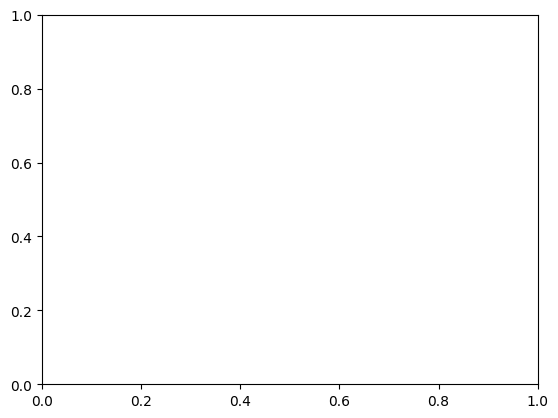

In [16]:
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

In [ ]:
#학습 시킨 모델 저장
output_dir = "content/model"

import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.save_pretrained(output_dir) #model

tokenizer.save_pretrained(output_dir) #tokenizer

('content/model/tokenizer_config.json',
 'content/model/special_tokens_map.json',
 'content/model/vocab.txt',
 'content/model/added_tokens.json')

# Cross Validation 학습

In [20]:
from sklearn.model_selection import KFold

kf_split_num = 5
num_epochs = 5

kf = KFold(n_splits=kf_split_num, shuffle=True, random_state=42)

test_accuracies = [[0] * kf_split_num for _ in range(num_epochs)]

for fold, (train_idx,valid_idx) in enumerate(kf.split(range(len(train_data)))):
    
    # fold로 나눠진 인덱스로 train_data 한번 더 나누기
    k_train_data = TensorDataset(train_inputs[train_idx], train_masks[train_idx], train_labels[train_idx])
    k_valid_data = TensorDataset(train_inputs[valid_idx], train_masks[valid_idx], train_labels[valid_idx])

    k_train_sampler = RandomSampler(k_train_data)
    k_train_dataloader = DataLoader(k_train_data, sampler=k_train_sampler, batch_size=batch_size)

    k_valid_sampler = SequentialSampler(k_valid_data)
    k_valid_dataloader = DataLoader(k_valid_data, sampler=k_valid_sampler, batch_size=batch_size)

    model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-small-v3-discriminator", num_labels=7)
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=5e-5)  

    # 모델 학습
    for epoch in range(num_epochs):
        # 학습 모드로 변경
        model.train()
        
        # 손실값 초기화
        total_train_loss = 0
        total_train_accuracy = 0
        
        # 배치별로 학습
        for step, batch in enumerate(k_train_dataloader):
            # 배치 데이터 GPU로 이동
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # 그래디언트 초기화
            optimizer.zero_grad()
            
            # forward 수행
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]

            # 손실값 누적
            total_train_loss += loss.item()
        
            # 예측값 추출
            preds = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
        
           # 정확도 계산
            total_train_accuracy += flat_accuracy(preds, label_ids)
            
            # backward 수행 및 그래디언트 클리핑
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            # 옵티마이저 업데이트
            optimizer.step()
            
        # 평균 손실값 계산
        avg_train_loss = total_train_loss / len(k_train_dataloader)
        avg_train_accuracy = total_train_accuracy / len(k_train_dataloader)
        
        # 예측값 추출
        preds = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
            
        # 정확도 계산
        total_train_accuracy += flat_accuracy(preds, label_ids)
        
        # 검증 모드로 변경
        model.eval()
        
        # 검증 데이터셋을 이용한 검증
        total_valid_accuracy = 0
        total_valid_loss = 0
        
        for batch in k_valid_dataloader:
            # 배치 데이터 GPU로 이동
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # 그래디언트 계산하지 않음
            with torch.no_grad():
                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                loss = outputs[0]
                logits = outputs[1]
                
            # 검증 손실값 누적
            total_valid_loss += loss.item()
            
            # 예측값 추출
            preds = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            
            # 정확도 계산
            total_valid_accuracy += flat_accuracy(preds, label_ids)
        
        # 평균 검증 손실값 및 정확도 계산
        avg_valid_accuracy = total_valid_accuracy / len(k_valid_dataloader)
        avg_valid_loss = total_valid_loss / len(k_valid_dataloader)

        total_test_accuracy = 0
        total_test_loss = 0
      
        for batch in test_dataloader:
            # 배치 데이터 GPU로 이동
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
        
            # 그래디언트 계산하지 않음
            with torch.no_grad():
                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                loss = outputs[0]
                logits = outputs[1]
                
            # 검증 손실값 누적
            total_test_loss += loss.item()
            
           # 예측값 추출
            preds = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            
            # 정확도 계산
            total_test_accuracy += flat_accuracy(preds, label_ids)
        
        # 평균 검증 손실값 및 정확도 계산
        avg_test_accuracy = total_test_accuracy / len(test_dataloader)
        avg_test_loss = total_test_loss / len(test_dataloader)
        
        # 결과 출력
        print(f"Fold {fold+1}/{kf_split_num}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Average training loss: {avg_train_loss:.4f}")
        print(f"Average training accuracy: {avg_train_accuracy:.4f}")
        print(f"Average validation loss: {avg_valid_loss:.4f}")
        print(f"Average validation accuracy: {avg_valid_accuracy:.4f}")
        print(f"Average test loss: {avg_test_loss:.4f}")
        print(f"Average test accuracy: {avg_test_accuracy:.4f}")
        print("======================================")

        test_accuracies[fold][epoch] = avg_test_accuracy

Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized

Fold 1/5
Epoch 1/5
Average training loss: 1.5190
Average training accuracy: 0.4399
Average validation loss: 1.1949
Average validation accuracy: 0.5871
Average test loss: 1.1980
Average test accuracy: 0.5818
Fold 1/5
Epoch 2/5
Average training loss: 1.0982
Average training accuracy: 0.6131
Average validation loss: 1.0151
Average validation accuracy: 0.6464
Average test loss: 1.0184
Average test accuracy: 0.6404
Fold 1/5
Epoch 3/5
Average training loss: 0.9376
Average training accuracy: 0.6689
Average validation loss: 1.0286
Average validation accuracy: 0.6452
Average test loss: 1.0197
Average test accuracy: 0.6493
Fold 1/5
Epoch 4/5
Average training loss: 0.8367
Average training accuracy: 0.7040
Average validation loss: 0.9418
Average validation accuracy: 0.6670
Average test loss: 0.9255
Average test accuracy: 0.6716
Fold 1/5
Epoch 5/5
Average training loss: 0.7502
Average training accuracy: 0.7366
Average validation loss: 0.9606
Average validation accuracy: 0.6651
Average test loss: 0.

Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized

Fold 2/5
Epoch 1/5
Average training loss: 1.5247
Average training accuracy: 0.4299
Average validation loss: 1.2546
Average validation accuracy: 0.5622
Average test loss: 1.2376
Average test accuracy: 0.5620
Fold 2/5
Epoch 2/5
Average training loss: 1.0978
Average training accuracy: 0.6138
Average validation loss: 1.0494
Average validation accuracy: 0.6378
Average test loss: 1.0370
Average test accuracy: 0.6326
Fold 2/5
Epoch 3/5
Average training loss: 0.9339
Average training accuracy: 0.6697
Average validation loss: 1.0222
Average validation accuracy: 0.6473
Average test loss: 0.9978
Average test accuracy: 0.6490
Fold 2/5
Epoch 4/5
Average training loss: 0.8313
Average training accuracy: 0.7081
Average validation loss: 0.9638
Average validation accuracy: 0.6627
Average test loss: 0.9436
Average test accuracy: 0.6682
Fold 2/5
Epoch 5/5
Average training loss: 0.7477
Average training accuracy: 0.7360
Average validation loss: 0.9790
Average validation accuracy: 0.6715
Average test loss: 0.

Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized

Fold 3/5
Epoch 1/5
Average training loss: 1.5313
Average training accuracy: 0.4323
Average validation loss: 1.2021
Average validation accuracy: 0.5715
Average test loss: 1.1826
Average test accuracy: 0.5833
Fold 3/5
Epoch 2/5
Average training loss: 1.0902
Average training accuracy: 0.6201
Average validation loss: 1.0272
Average validation accuracy: 0.6338
Average test loss: 1.0117
Average test accuracy: 0.6391
Fold 3/5
Epoch 3/5
Average training loss: 0.9309
Average training accuracy: 0.6732
Average validation loss: 0.9788
Average validation accuracy: 0.6505
Average test loss: 0.9537
Average test accuracy: 0.6587
Fold 3/5
Epoch 4/5
Average training loss: 0.8247
Average training accuracy: 0.7092
Average validation loss: 0.9623
Average validation accuracy: 0.6635
Average test loss: 0.9334
Average test accuracy: 0.6746
Fold 3/5
Epoch 5/5
Average training loss: 0.7395
Average training accuracy: 0.7392
Average validation loss: 1.0007
Average validation accuracy: 0.6650
Average test loss: 0.

Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized

Fold 4/5
Epoch 1/5
Average training loss: 1.5067
Average training accuracy: 0.4445
Average validation loss: 1.1619
Average validation accuracy: 0.5921
Average test loss: 1.1443
Average test accuracy: 0.5975
Fold 4/5
Epoch 2/5
Average training loss: 1.0849
Average training accuracy: 0.6181
Average validation loss: 1.0256
Average validation accuracy: 0.6382
Average test loss: 1.0147
Average test accuracy: 0.6415
Fold 4/5
Epoch 3/5
Average training loss: 0.9313
Average training accuracy: 0.6730
Average validation loss: 0.9972
Average validation accuracy: 0.6581
Average test loss: 0.9870
Average test accuracy: 0.6585
Fold 4/5
Epoch 4/5
Average training loss: 0.8357
Average training accuracy: 0.7051
Average validation loss: 0.9586
Average validation accuracy: 0.6703
Average test loss: 0.9424
Average test accuracy: 0.6721
Fold 4/5
Epoch 5/5
Average training loss: 0.7514
Average training accuracy: 0.7343
Average validation loss: 0.9808
Average validation accuracy: 0.6673
Average test loss: 0.

Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized

Fold 5/5
Epoch 1/5
Average training loss: 1.4854
Average training accuracy: 0.4601
Average validation loss: 1.1677
Average validation accuracy: 0.5869
Average test loss: 1.1578
Average test accuracy: 0.5922
Fold 5/5
Epoch 2/5
Average training loss: 1.0742
Average training accuracy: 0.6244
Average validation loss: 1.0136
Average validation accuracy: 0.6367
Average test loss: 1.0028
Average test accuracy: 0.6413
Fold 5/5
Epoch 3/5
Average training loss: 0.9200
Average training accuracy: 0.6776
Average validation loss: 0.9723
Average validation accuracy: 0.6580
Average test loss: 0.9609
Average test accuracy: 0.6579
Fold 5/5
Epoch 4/5
Average training loss: 0.8230
Average training accuracy: 0.7103
Average validation loss: 0.9619
Average validation accuracy: 0.6635
Average test loss: 0.9559
Average test accuracy: 0.6640
Fold 5/5
Epoch 5/5
Average training loss: 0.7467
Average training accuracy: 0.7382
Average validation loss: 0.9915
Average validation accuracy: 0.6704
Average test loss: 0.

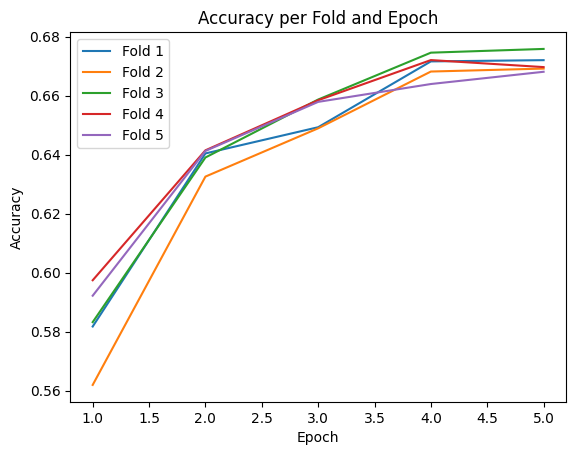

In [21]:
# Epoch 번호 리스트 (x축)
epoch_numbers = range(1, len(test_accuracies[0]) + 1)

# 각 Fold별로 그래프 그리기
for fold, accuracies in enumerate(test_accuracies, start=1):
    plt.plot(epoch_numbers, accuracies, label=f'Fold {fold}')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Fold and Epoch')
plt.legend()
plt.show()

# 음악 데이터셋 생성하기

In [ ]:
model.load_state_dict(torch.load('pytorch_model.bin', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
songs_file = files.upload()

Saving song_data_new.csv to song_data_new.csv


In [ ]:
import re

songs_df = pd.read_csv('song_data_new.csv', encoding='utf-8-sig')
lyrics = list(songs_df['lyric'])

sentence_unit = 4
total_probs = np.zeros(shape=7)

for lyric in lyrics:
    sentences = lyric.split('/')

    idx = 0
    repeat_cnt = 0
    avg_probs = [0 for _ in range(7)]

    while idx < len(sentences):
        repeat_cnt += 1

        # sentence_unit (4) 개의 구절을 하나의 문장으로 취급
        if idx+sentence_unit <= len(sentences):
            sentence = sentences[idx:idx+sentence_unit]
        else:
            sentence = sentences[idx:len(sentences)]
        idx += sentence_unit

        merged_sentence = ''.join(sentence)

        # 영어는 제거
        merged_sentence = re.sub('[a-z][A-Z]', '', merged_sentence)

        # 감정 확률 얻기
        probs, _ = get_emotion_prob(merged_sentence)
        avg_probs = [x+y for x, y in zip(avg_probs, probs)]

    avg_probs = [x/repeat_cnt for x in avg_probs]
    total_probs = np.vstack((total_probs, avg_probs))


In [ ]:
total_probs = total_probs[1:]
songs_df['행복'] = total_probs[:,0]
songs_df['슬픔'] = total_probs[:,1]
songs_df['공포'] = total_probs[:,2]
songs_df['중립'] = total_probs[:,3]
songs_df['분노'] = total_probs[:,4]
songs_df['혐오'] = total_probs[:,5]
songs_df['놀람'] = total_probs[:,6]

songs_df.to_csv('song_with_percentage_data2.csv', encoding='utf-8-sig')

# 사용자 입력 문장 테스트

In [ ]:
def get_emotion_prob(text):
    # 입력된 문장을 토큰화
    inputs = tokenizer(text, return_tensors="pt")

    # GPU 사용 여부에 따라 입력을 적절한 장치로 이동
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # 모델에 입력값을 넣고 예측
    outputs = model(**inputs)
    logits = outputs.logits

    # 예측 결과를 softmax 함수를 이용하여 확률값으로 변환
    probs = torch.nn.functional.softmax(logits, dim=-1)

    # 확률값 중에서 가장 큰 값의 인덱스를 예측 클래스로 사용
    pred_class = torch.argmax(probs, dim=-1)

    # 확률값 및 예측 클래스 출력
    class_dict = {0:'행복', 1:'슬픔', 2:'공포', 3:'중립', 4:'분노', 5:'혐오', 6:'놀람'}

    return probs.tolist()[0], class_dict

get_emotion_prob('고마워')

([0.1821056455373764,
  0.5448974370956421,
  0.151245579123497,
  0.007316546514630318,
  0.03537270054221153,
  0.07204297930002213,
  0.00701920036226511],
 {0: '행복', 1: '슬픔', 2: '공포', 3: '중립', 4: '분노', 5: '혐오', 6: '놀람'})

In [ ]:
text = input()
get_emotion_prob(text)

어떻게 그럴수가 있어


([0.03157534822821617,
  0.21506185829639435,
  0.12782427668571472,
  0.0017880391096696258,
  0.16528284549713135,
  0.4488920271396637,
  0.009575609117746353],
 {0: '행복', 1: '슬픔', 2: '공포', 3: '중립', 4: '분노', 5: '혐오', 6: '놀람'})

# 사용자 입력을 받아서 유사도 높은 음악 추출해주기

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np

def cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b))

def recommend_song(input_text):
    input_p = get_emotion_prob(input_text)[0]
    sim_lst = [(cos_sim(input_p, p), i) for i, p in enumerate(song_percentage)]
    cos_similarity, max_similar_idx = max(sim_lst)
    max_similar_song = songs_df['title'][max_similar_idx]

    return cos_similarity, max_similar_idx, max_similar_song 

In [ ]:
songs_file = files.upload()
songs_df = pd.read_csv('song_with_percentage_data.csv', encoding='cp949')
song_percentage = np.vstack((songs_df['행복'], songs_df['슬픔'], songs_df['공포'], songs_df['중립'], songs_df['분노'], songs_df['혐오'], songs_df['놀람']))
song_percentage = np.transpose(song_percentage)

Saving song_with_percentage_data.csv to song_with_percentage_data (1).csv


In [ ]:
print(recommend_song('오늘 날씨가 좋네'))
print(recommend_song('너무 무섭다'))
print(recommend_song('상사 때문에 화나'))
print(recommend_song('슬픈 일을 겪었어'))

(0.6204148672519358, 449, '미궁')
(0.8413465660688139, 3, '선 (Feat. 우효) (45.7cm)')
(0.9999992799257476, 459, "I Can't Get You Off My Mind")
(0.9999997423491995, 380, '늦은 후회')
